In [1]:
import torch
from torchvision import transforms
from torch.autograd import Variable
from dataset import DatasetFromFolder
from model import Generator, Discriminator
import argparse
import os
import utils
import numpy as np

In [2]:
# Directories for loading data and saving results
data_dir = 'facades/'
save_dir = 'results/'
model_dir = 'model/'

In [3]:
if not os.path.exists(save_dir):
    os.mkdir(save_dir)
if not os.path.exists(model_dir):
    os.mkdir(model_dir)

In [4]:
transform = transforms.Compose([transforms.Scale(256),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))])

/home/lex/workflow/miniconda3/envs/trading/lib/python3.8/site-packages/torchvision/transforms/transforms.py:279: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  warnings.warn("The use of the transforms.Scale transform is deprecated, " +


In [5]:
train_data = DatasetFromFolder(data_dir, subfolder='train', direction='BtoA', transform=transform,
                               resize_scale=286, crop_size=256, fliplr=True)
train_data_loader = torch.utils.data.DataLoader(dataset=train_data,
                                                batch_size=1,
                                                shuffle=True)

In [6]:
test_data = DatasetFromFolder(data_dir, subfolder='test', direction='BtoA', transform=transform)
test_data_loader = torch.utils.data.DataLoader(dataset=test_data,
                                               batch_size=1,
                                               shuffle=False)

In [7]:
test_input, test_target = test_data_loader.__iter__().__next__()

In [8]:
G = Generator(3, 64, 3)
D = Discriminator(6, 64, 1)
G.cuda()
D.cuda()
G.normal_weight_init(mean=0.0, std=0.02)
D.normal_weight_init(mean=0.0, std=0.02)

/home/lex/workflow/made/advanced-dl/hw/hw3/model.py:102: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  torch.nn.init.normal(m.conv.weight, mean, std)
/home/lex/workflow/made/advanced-dl/hw/hw3/model.py:104: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  torch.nn.init.normal(m.deconv.weight, mean, std)
/home/lex/workflow/made/advanced-dl/hw/hw3/model.py:130: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  torch.nn.init.normal(m.conv.weight, mean, std)


In [9]:
# Loss function
BCE_loss = torch.nn.BCELoss().cuda()
L1_loss = torch.nn.L1Loss().cuda()

# Optimizers
G_optimizer = torch.optim.Adam(G.parameters(), lr=0.0002, betas=(0.5, 0.999))
D_optimizer = torch.optim.Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999))

# Training GAN
D_avg_losses = []
G_avg_losses = []

Epoch 0/20 D_loss: 0.3067, G_loss: 37.2085


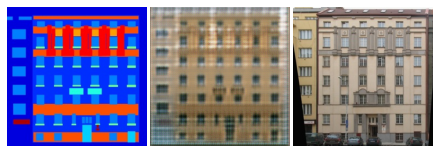

Epoch 1/20 D_loss: 0.2761, G_loss: 37.8852


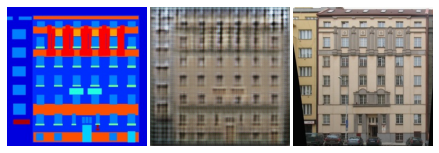

Epoch 2/20 D_loss: 0.2943, G_loss: 37.821


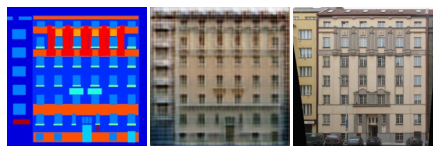

Epoch 3/20 D_loss: 0.3116, G_loss: 37.8423


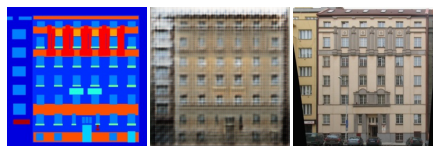

Epoch 4/20 D_loss: 0.3146, G_loss: 37.7958


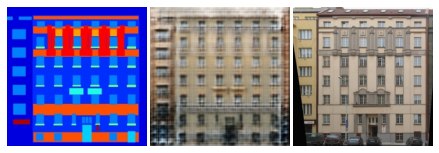

Epoch 5/20 D_loss: 0.2961, G_loss: 37.7316


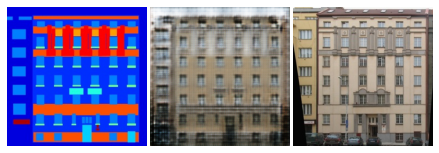

Epoch 6/20 D_loss: 0.3245, G_loss: 37.3142


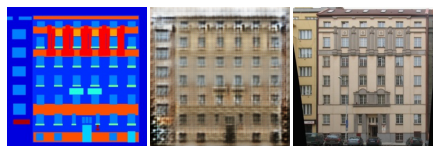

Epoch 7/20 D_loss: 0.3112, G_loss: 37.2053


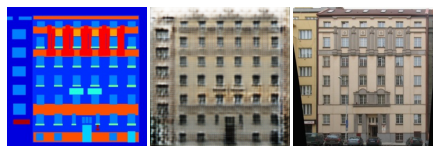

Epoch 8/20 D_loss: 0.3425, G_loss: 36.9391


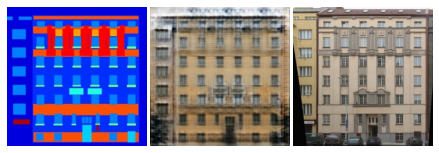

Epoch 9/20 D_loss: 0.331, G_loss: 36.7047


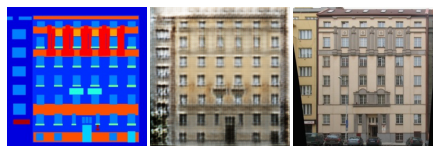

Epoch 10/20 D_loss: 0.3083, G_loss: 36.208


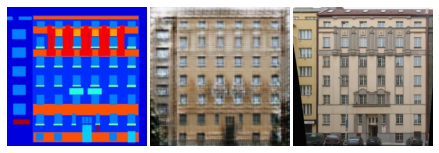

Epoch 11/20 D_loss: 0.3369, G_loss: 35.991


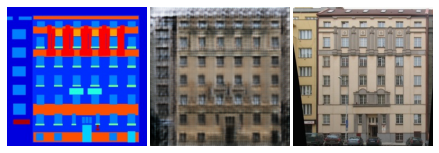

Epoch 12/20 D_loss: 0.3248, G_loss: 35.7997


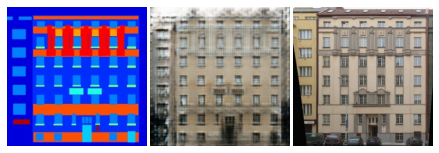

Epoch 13/20 D_loss: 0.3515, G_loss: 35.4579


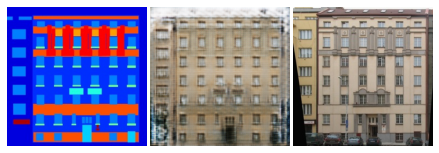

Epoch 14/20 D_loss: 0.354, G_loss: 35.2971


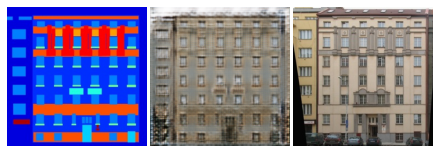

Epoch 15/20 D_loss: 0.3242, G_loss: 35.0357


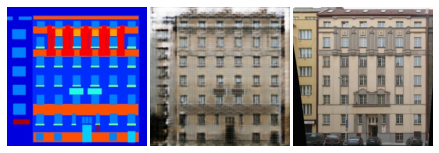

Epoch 16/20 D_loss: 0.3445, G_loss: 34.8374


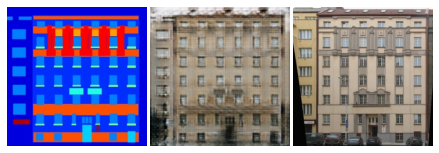

Epoch 17/20 D_loss: 0.343, G_loss: 34.8628


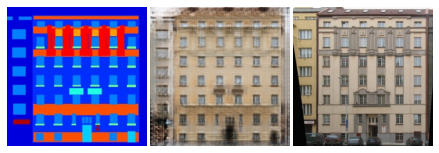

Epoch 18/20 D_loss: 0.3309, G_loss: 34.5555


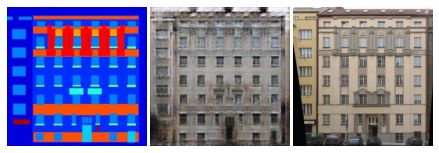

Epoch 19/20 D_loss: 0.3369, G_loss: 34.4947


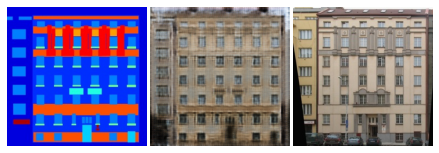

In [10]:
num_epoch = 20
for epoch in range(num_epoch):
    step = 0
    D_losses = []
    G_losses = []

    # training
    for i, (input, target) in enumerate(train_data_loader):

        # input & target image data
        x_ = Variable(input.cuda())
        y_ = Variable(target.cuda())

        # Train discriminator with real data
        D_real_decision = D(x_, y_).squeeze()
        real_ = Variable(torch.ones(D_real_decision.size()).cuda())
        D_real_loss = BCE_loss(D_real_decision, real_)

        # Train discriminator with fake data
        gen_image = G(x_)
        D_fake_decision = D(x_, gen_image).squeeze()
        fake_ = Variable(torch.zeros(D_fake_decision.size()).cuda())
        D_fake_loss = BCE_loss(D_fake_decision, fake_)

        # Back propagation
        D_loss = (D_real_loss + D_fake_loss) * 0.5
        D.zero_grad()
        D_loss.backward()
        D_optimizer.step()

        # Train generator
        gen_image = G(x_)
        D_fake_decision = D(x_, gen_image).squeeze()
        G_fake_loss = BCE_loss(D_fake_decision, real_)

        # L1 loss
        l1_loss = 100 * L1_loss(gen_image, y_)

        # Back propagation
        G_loss = G_fake_loss + l1_loss
        G.zero_grad()
        G_loss.backward()
        G_optimizer.step()

        # loss values
        D_losses.append(D_loss.data.item())
        G_losses.append(G_loss.data.item())
        
#         if i % 100 == 50:
#             print('Epoch [%d/%d], Step [%d/%d], D_loss: %.4f, G_loss: %.4f'
#                   % (epoch+1, 100, i+1, len(train_data_loader), D_loss.data, G_loss.data))
        step += 1
    
    D_avg_loss = np.mean(D_losses)
    G_avg_loss = np.mean(G_losses)

    
    D_avg_losses.append(D_avg_loss)
    G_avg_losses.append(G_avg_loss)
    
    print(f"Epoch {epoch}/{num_epoch} D_loss: {round(D_avg_loss, 4)}, G_loss: {round(G_avg_loss, 4)}")
    # Show result for test image
    gen_image = G(Variable(test_input.cuda()))
    gen_image = gen_image.cpu().data
    utils.plot_test_result(test_input, test_target, gen_image, epoch, show=True, fig_size=(10, 10))

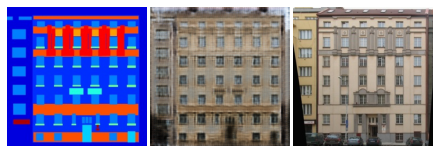

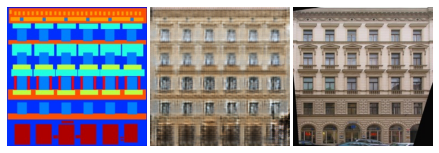

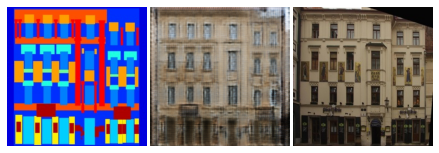

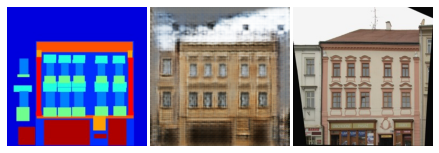

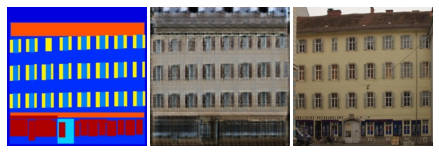

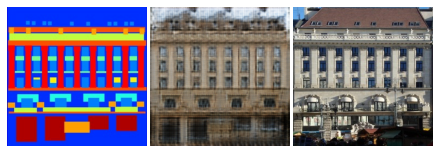

In [11]:
for i, (input, target) in enumerate(test_data_loader):
    if i > 5:
        break
    test_input = input
    test_target = target
    gen_image = G(Variable(input.cuda()))
    gen_image = gen_image.cpu().data
    utils.plot_test_result(test_input, test_target, gen_image, epoch, show=True, fig_size=(10, 10))